In [1]:
# Loading functions for calculating Ezh2 binding in methylarray datasets and plotting Figs 3a & 4c.

data='../data/'
# data/chip contains chip-seq data
# data/meth/a contains DNA methylation array data and sample age information

import pandas as pd
import pyBigWig 
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
sns.set_style('white')
sns.set_context("paper")

ez=pyBigWig.open(data+'chip/ENCFF109KCQ.bigWig') # Human ESC (H1) ezh2 chip seq
su=pyBigWig.open(data+'chip/ENCFF090OSN.bigWig') # Human ESC (H1) ezh2 chip seq
mez1=pyBigWig.open(data+'chip/SRX2528911.bw') # Mouse ESC (E14) ezh2 chip
beta_threshold=.25

#loading GSE dataframe with methylation array data
def get_df(gse,age_cats,age_labels):
    df=pd.read_csv(data+'meth/a/'+gse+'.csv',index_col=0,engine='c')
    df=df.T
    if 'age' not in df.columns:
        df=df.merge(age,left_index=True,right_index=True)
    df['c']=pd.cut(df.age,age_cats,include_lowest=True,labels=age_labels)
    return(df)

#plot global methylation
def pwg(df,w,figure=''):
    dg=df.drop('age',axis=1).groupby('c').mean().T    
    color=[]
    pl=dg.mean()
    fig, ax = plt.subplots(figsize=(w,2));
    sns.barplot(pl)
    if len(color)>0:
        ax=sns.barplot(data=pl,x=pl.index,y=0,palette=color);        
    ax.set(ylabel='DNAm',title='All CpGs');
    ax.set_xticklabels(age_labels);
    plt.xticks(rotation=90,fontsize=8);
    fig.savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg

#PRC2 AgeIndex plot - plotting percentage methylation (rolling average) against Low methylated CpGs (LMCs) sorted by PRC2 binding 
def prc(dg,mh,title='Low methylated CpGs',figure=''):
    dg=dg.merge(mh['pr'],left_index=True,right_index=True)
    dg=dg.sort_values('pr')#.reset_index()
    pl=dg.drop('pr',axis=1).rolling(10**4).mean()
    ax=pl.plot(figsize=(3,2))
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('LMCs ranked by PRC2 binding', fontsize=10)
    ax.set(ylabel='DNAm',title=title);
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    return dg

#Zoomed in plot of right hand side of PRC2 AgeIndex Plot
def prch(dg,figure=''): 
    legend_title='years'
    pl=dg.drop('pr',axis=1).tail(20000).rolling(10000).mean()
    ax=pl.plot(figsize=(1,2))
    ax.set_xticks([])
    ax.set_xlabel('PRC2 binding', fontsize=10)  
    ax.set_title('High-PRC2 CpGs');   
    handles, labels = ax.get_legend_handles_labels()    
    ax.legend(handles[::-1], labels[::-1],title=legend_title,loc='center left', bbox_to_anchor=(1, 0.5))
    ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
    

In [2]:
#prepare Human 450 Methyl Array manifest
man=pd.read_table(data+'meth/a/HM450.hg38.manifest.gencode.v36.tsv.gz',index_col=2,engine='c',
                  usecols=['CpG_chrm','CpG_beg','probeID',])                
man=man.dropna()
man['b']=man['CpG_beg'].astype(int)
man['ch']=man['CpG_chrm']
man=man[~man['ch'].isin(['chrX','chrY','chrM'])].copy()
man['ez']=man.apply(lambda x: ez.stats(x['ch'],x['b'],x['b']+1)[0],axis=1)
man['su']=man.apply(lambda x: su.stats(x['ch'],x['b'],x['b']+1)[0],axis=1)
man['pr']=man[['ez','su']].mean(1)    
len(man)

473878

656


/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dg=df.drop('age',axis=1).groupby('c').mean().T
/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_labels);


178616


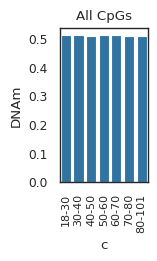

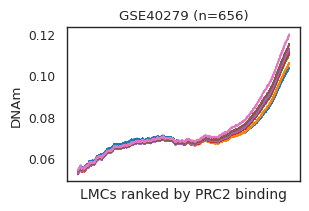

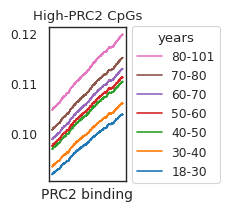

In [4]:
# Fig 3a - GSE40279
gse='GSE40279'
age_cats=[18,30,40,50,60,70,80,101]
age_labels=['18-30','30-40','40-50','50-60','60-70','70-80','80-101']
w=len(age_cats)*.13+.1
age=pd.read_csv(data+'meth/a/'+gse+'a.csv',index_col=0)
print(len(age))
df=get_df(gse,age_cats,age_labels)
dg=pwg(df,w,figure='Fig3_'+gse+'_wg')
dfm=df.drop('c',axis=1).mean()
mh=man[man.index.isin(dfm[dfm<beta_threshold].index)].copy()
dg2=prc(dg,mh,title='GSE40279 (n=656)',figure='Fig3_'+gse+'_lmr')
print(len(mh))
prch(dg2,figure='Fig3_'+gse+'_prc')

689


/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dg=df.drop('age',axis=1).groupby('c').mean().T
/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_labels);


179084


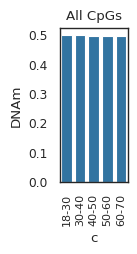

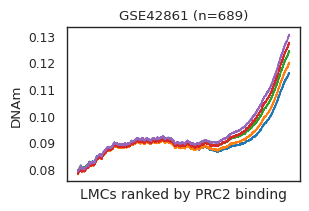

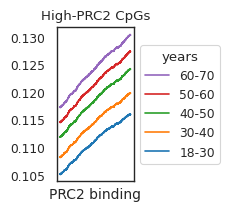

In [6]:
# Fig 3a - GSE42861
gse='GSE42861'
age_cats=[18,30,40,50,60,70]
age_labels=['18-30','30-40','40-50','50-60','60-70']
age=pd.read_csv(data+'meth/a/'+gse+'a.csv',index_col=0)
w=len(age_cats)*.13+.1
print(len(age))
df=get_df(gse,age_cats,age_labels)
dg=pwg(df,w,figure='Fig3_'+gse+'_wg')
dfm=df.drop('c',axis=1).mean()
mh=man[man.index.isin(dfm[dfm<beta_threshold].index)].copy()
dg2=prc(dg,mh, title='GSE42861 (n=689)',figure='Fig3_'+gse+'_lmr')
print(len(mh))
prch(dg2,figure='Fig3_'+gse+'_prc')

799


/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dg=df.drop('age',axis=1).groupby('c').mean().T
/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_labels);


179701


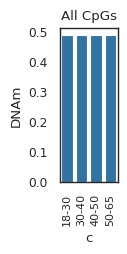

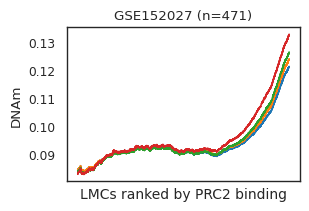

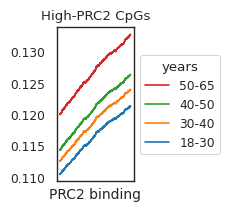

In [7]:
# Fig 3a - GSE152027
gse='GSE152027'
age_cats=[18,30,40,50,65]
age_labels=['18-30','30-40','40-50','50-65']
age=pd.read_csv(data+'meth/a/'+gse+'a.csv',index_col=0)
w=len(age_cats)*.13+.1
print(len(age))
df=get_df(gse,age_cats,age_labels)
df=df.drop('status',axis=1) # remove additional sample information 
dg=pwg(df,w,figure='Fig3_'+gse+'_wg')
dfm=df.drop('c',axis=1).mean()
mh=man[man.index.isin(dfm[dfm<beta_threshold].index)].copy()
dg2=prc(dg,mh,title='GSE152027 (n=471)',figure='Fig3_'+gse+'_lmr')
print(len(mh))
prch(dg2,figure='Fig3_'+gse+'_prc')

2711


/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dg=df.drop('age',axis=1).groupby('c').mean().T
/local/scratch/moqri/slrmtmp.43007249/ipykernel_17990/3020314360.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_labels);


176983


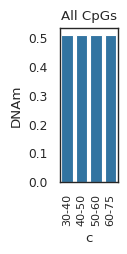

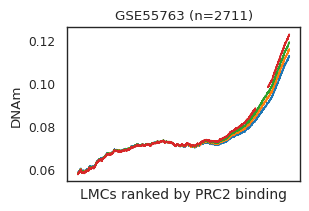

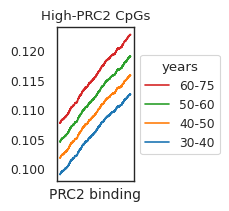

In [8]:
# Fig 3a - GSE55763
gse='GSE55763'
age_cats=[30,40,50,60,75]
age_labels=['30-40','40-50','50-60','60-75']
age=pd.read_csv(data+'meth/a/'+gse+'a.csv',index_col=0)
w=len(age_cats)*.13+.1
print(len(age))
df=get_df(gse,age_cats,age_labels)
df=df.drop('gse',axis=1)
dg=pwg(df,w,figure='Fig3_'+gse+'_wg')
dfm=df.drop('c',axis=1).mean()
mh=man[man.index.isin(dfm[dfm<beta_threshold].index)].copy()
dg2=prc(dg,mh,title='GSE55763 (n=2711)',figure='Fig3_'+gse+'_lmr')
print(len(mh))
prch(dg2,figure='Fig3_'+gse+'_prc')

In [9]:
%%time
# Loading reprogramming data for Fig 4c 
df=pd.read_csv('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE190nnn/GSE190665/suppl/GSE190665_datBetaNormalized.csv.gz',index_col=0)
df.columns=df.columns.str[1:]
meta='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE190nnn/GSE190665/matrix/GSE190665_series_matrix.txt.gz'
meta=pd.read_csv(meta,sep='\t',skiprows=35,index_col=0).T
meta=meta.iloc[:,[6,8,11,12,14]]
meta.columns=['cell','age','gen','treatment','duration']
meta=meta[meta['cell']=='Skin']
meta=meta[meta['gen']=='genotype: 4F']
meta=meta[meta['age']!='age: 0.25']
meta=meta[meta['duration'].isin(['durationtreatment: 7','durationtreatment: 0','durationtreatment: NA'])]
meta=meta.sort_values('treatment')
skin=meta.index.str.split('.').str[2]

CPU times: user 2.08 s, sys: 864 ms, total: 2.95 s
Wall time: 4.33 s


In [10]:
%%time
#prepare Mouse Methylation Array (MammalianMethylationConsortium) manifest
man='https://github.com/shorvath/MammalianMethylationConsortium/raw/main/Annotations%2C%20Amin%20Haghani/Manifest%2C%20HorvathMammalMethylChip40.csv.zip'
man=pd.read_csv(man,index_col=0,usecols=['IlmnID','Mouse.GRCm38.100_seqnames','Mouse.GRCm38.100_CGstart'])
man.columns=['b','ch']
man=man[~man['ch'].isna()].copy()
man['ch']='chr'+man['ch']
man['b']=man.b.astype(int)
man['ez']=man.apply(lambda x: mez1.stats(x['ch'],x['b'],x['b']+1)[0],axis=1)
man=man.sort_values('ez').dropna().copy()
man.shape

CPU times: user 6.26 s, sys: 1.23 s, total: 7.49 s
Wall time: 47.4 s


(21969, 3)

In [11]:
man.columns=['pos','chrom','prc2']
man[['chrom','pos','prc2']].sort_values('prc2',ascending=False).to_csv('results/mamalian_prc2.csv')
pl=df[skin].mean()
top=man.tail(1000).index
wg=df[skin]
wg.columns=7*['control']+5*['OSKM']

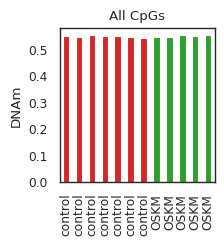

In [12]:
# Fig 4c - Plotting total methylation per sample
colors=7*['tab:red']+5*['tab:green']+['tab:red']
figure='f4_c_wg'
ax=wg.mean().plot(kind='bar',color=colors,figsize=(2,2))
ax.set(ylabel='DNAm',title='All CpGs');
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
plt.show()

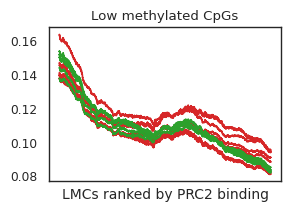

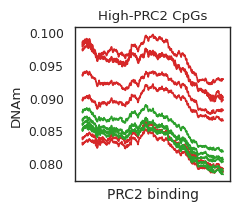

In [13]:
# Fig 4c - Plotting PRC2-AgeIndex (mean methylation per CpG sorted by EZH2 binding)
figure='f4_c_lmr'
dg=df[skin].merge(man['prc2'],left_index=True,right_index=True)
dg=dg[dg.mean(1)<.3]
dg.columns=7*['control']+5*['OSKM']+['prc2']
ax=dg.sort_values('prc2').reset_index(drop=True).drop('prc2',axis=1).rolling(1000).mean().plot(color=colors,figsize=(3,2))
ax.get_legend().remove()
ax.set_xticks([])
ax.set_xlabel('LMCs ranked by PRC2 binding', fontsize=10)
ax.set(ylabel='',title='Low methylated CpGs');   
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
plt.show()

figure='f4_c_prc'
pl=dg.sort_values('prc2').drop('prc2',axis=1).reset_index(drop=True).tail(1000).rolling(500).mean().dropna()
ax=pl.plot(color=colors,figsize=(2,2))
ax.get_legend().remove()
ax.set_xticks([])
ax.set_xlabel('PRC2 binding', fontsize=10)
ax.set(ylabel='DNAm',title='High-PRC2 CpGs');   
ax.get_figure().savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight')
plt.show()

In [15]:
#Extracting top 1000 PRC2 binding CpGs
pl=dg.sort_values('prc2').drop('prc2',axis=1).tail(1000).mean().to_frame()

In [16]:
pl['group']=pl.index

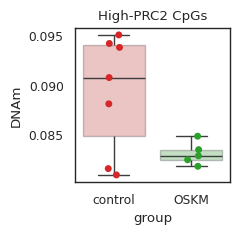

In [17]:
# Fig 4c - Plotting boxplot of mean methylation for top 1000 PRC2 binding CpGs
figure='f4_c_reprogram_prc'
fig, ax = plt.subplots(figsize=(2,2));
ax=sns.boxplot(data=pl,x='group',y=0,hue='group',palette=['tab:red','tab:green'],boxprops=dict(alpha=.3))
ax=sns.stripplot(data=pl,x='group',y=0,hue='group',palette=['tab:red','tab:green'])
ax.set(ylabel='DNAm',title='High-PRC2 CpGs');   
fig.savefig('figures/'+figure+'.png', dpi=600,bbox_inches='tight');